In [1]:
!pip list

Package                       Version
----------------------------- ------------------
absl-py                       0.10.0
alembic                       1.0.0
algopy                        0.5.7
apache-beam                   2.25.0
astunparse                    1.6.3
async-generator               1.10
atari-py                      0.2.6
attrs                         20.3.0
avro-python3                  1.9.2.1
backcall                      0.1.0
batchspawner                  0.9.0.dev0
beautifulsoup4                4.6.3
bleach                        2.1.4
bokeh                         0.13.0
boto                          2.49.0
boto3                         1.8.6
botocore                      1.11.6
bz2file                       0.98
cachetools                    4.1.1
certifi                       2018.8.24
cffi                          1.14.4
chardet                       3.0.4
cloudpickle                   1.6.0
contextlib2                   0.6.0.post1
crcmod                     

In [2]:
pwd

'/home/014530971'

In [3]:
!protoc --version

libprotoc 3.9.2


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
import object_detection

#from object_detection.utils import label_map_util
#from object_detection.utils import config_util
#from object_detection.utils import visualization_utils as viz_utils
#from object_detection.builders import model_builder


In [5]:
tf.__version__

'2.3.1'

In [6]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [7]:

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
    """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
    tuple_list = []
    kp_list = eval_config.keypoint_edge
    for edge in kp_list:
        tuple_list.append((edge.start, edge.end))
    return tuple_lis

In [8]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {'centernet_with_keypoints': 'centernet_hg104_512x512_kpts_coco17_tpu-32', 'centernet_without_keypoints': 'centernet_hg104_512x512_coco17_tpu-8'}

model_display_name = 'centernet_without_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

In [9]:
!ls models/research/object_detection/test_data/

context_rcnn_camera_trap.config  snapshot_serengeti_sequence_examples.record
pets_examples.record		 ssd_mobilenet_v1_fpp.config


In [10]:
cd /data/cmpe249-f20/Shifa

/data/cmpe249-f20/Shifa


In [11]:
!mkdir exported-models

mkdir: cannot create directory ‘exported-models’: File exists


In [12]:
ls

exported-models/
json_TFRecordTrain-.json
json_TFRecordVal-.json
myoutputmodel/
pipeline_file.config*
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
TFRecordTrain--00000-of-00005.tfrecord
TFRecordTrain--00001-of-00005.tfrecord
TFRecordTrain--00002-of-00005.tfrecord
TFRecordTrain--00003-of-00005.tfrecord
TFRecordTrain--00004-of-00005.tfrecord
TFRecordVal--00000-of-00005.tfrecord
TFRecordVal--00001-of-00005.tfrecord
TFRecordVal--00002-of-00005.tfrecord
TFRecordVal--00003-of-00005.tfrecord
TFRecordVal--00004-of-00005.tfrecord


In [13]:
Local_Train_Path='./TFRecordTrain*'
train_filenames = tf.io.gfile.glob(Local_Train_Path)

In [14]:

#ref: https://github.com/tensorflow/models/blob/master/official/vision/detection/dataloader/tf_example_decoder.py
def _decode_image(parsed_tensors):
    """Decodes the image and set its static shape."""
    image = tf.io.decode_image(parsed_tensors['image/encoded'], channels=3)
    image.set_shape([None, None, 3])
    return image

def _decode_boxes(parsed_tensors):
    """Concat box coordinates in the format of [ymin, xmin, ymax, xmax]."""
    xmin = parsed_tensors['image/object/bbox/xmin']
    xmax = parsed_tensors['image/object/bbox/xmax']
    ymin = parsed_tensors['image/object/bbox/ymin']
    ymax = parsed_tensors['image/object/bbox/ymax']
    print(ymax)

    return tf.stack([ymin, xmin, ymax, xmax], axis=-1)

def _decode_areas(parsed_tensors):
    xmin = parsed_tensors['image/object/bbox/xmin']
    xmax = parsed_tensors['image/object/bbox/xmax']
    ymin = parsed_tensors['image/object/bbox/ymin']
    ymax = parsed_tensors['image/object/bbox/ymax']
    return tf.cond(
        tf.greater(tf.shape(parsed_tensors['image/object/area'])[0], 0),
        lambda: parsed_tensors['image/object/area'],
        lambda: (xmax - xmin) * (ymax - ymin))

def read_tfrecord(example):
    features = {
        'image/encoded':
            tf.io.FixedLenFeature((), tf.string),
        'image/source_id':
            tf.io.FixedLenFeature((), tf.string),
        'image/height':
            tf.io.FixedLenFeature((), tf.int64),
        'image/width':
            tf.io.FixedLenFeature((), tf.int64),
        'image/object/bbox/xmin':
            tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax':
            tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin':
            tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax':
            tf.io.VarLenFeature(tf.float32),
        'image/object/class/label':
            tf.io.VarLenFeature(tf.int64),
        'image/object/area':
            tf.io.VarLenFeature(tf.float32),
        'image/object/is_crowd':
            tf.io.VarLenFeature(tf.int64),
    }
    # features = {
    #     "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    #     "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    # }
    example = tf.io.parse_single_example(example, features)

    for k in example:
      if isinstance(example[k], tf.SparseTensor):
        if example[k].dtype == tf.string:
          example[k] = tf.sparse.to_dense(
              example[k], default_value='')
        else:
          example[k] = tf.sparse.to_dense(
              example[k], default_value=0)
          
    print("Got example")
    print(example['image/object/bbox/xmin'])
    image = _decode_image(example)
    print("Decoded image")
    boxes = _decode_boxes(example)
    print("Decoded boxes:", boxes)
    areas = _decode_areas(example)
    is_crowds = tf.cond(
        tf.greater(tf.shape(example['image/object/is_crowd'])[0], 0),
        lambda: tf.cast(example['image/object/is_crowd'], dtype=tf.bool),
        lambda: tf.zeros_like(example['image/object/class/label'], dtype=tf.bool))  # pylint: disable=line-too-long

    source_id = example['image/source_id']
    height=example['image/height']
    width=example['image/width']
    groundtruth_class=example['image/object/class/label']

    #image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.resize(image, IMAGE_SIZE)
    #image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    #class_label = example['class']
    print(groundtruth_class)
    decoded_tensors = {
        'image': image,
        'source_id': source_id,
        'height':height,
        'width':width,
        'groundtruth_classes': groundtruth_class,
        'groundtruth_is_crowd': is_crowds,
        'groundtruth_area': areas,
        'groundtruth_boxes': boxes,
    }
    return decoded_tensors#image, class_label

def load_dataset(filenames):
    option_no_order = tf.data.Options()
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

    
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [15]:
AUTO = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [640, 640] #[192, 192]
display_dataset=load_dataset(train_filenames)

Got example
Tensor("SparseToDense_2:0", shape=(None,), dtype=float32)
Decoded image
Tensor("SparseToDense_3:0", shape=(None,), dtype=float32)
Decoded boxes: Tensor("stack:0", shape=(None, 4), dtype=float32)
Tensor("SparseToDense_5:0", shape=(None,), dtype=int64)


In [16]:
decoded_tensors =next(iter(display_dataset))
decoded_tensors

{'image': <tf.Tensor: shape=(640, 640, 3), dtype=float32, numpy=
 array([[[0.8509804 , 1.        , 0.99215686],
         [0.84705883, 1.        , 0.9882353 ],
         [0.85490197, 0.99607843, 0.9882353 ],
         ...,
         [0.6333333 , 0.87254906, 0.9941176 ],
         [0.627451  , 0.8666667 , 0.9882353 ],
         [0.627451  , 0.8666667 , 0.9882353 ]],
 
        [[0.8607843 , 1.        , 0.9941176 ],
         [0.85882354, 1.        , 0.99215686],
         [0.85490197, 0.99607843, 0.9882353 ],
         ...,
         [0.6294118 , 0.8686274 , 0.9901961 ],
         [0.6294118 , 0.8686274 , 0.9901961 ],
         [0.61960787, 0.85882354, 0.98039216]],
 
        [[0.8666667 , 1.        , 0.99607843],
         [0.8627451 , 0.99607843, 0.99215686],
         [0.8568628 , 0.99803925, 0.9901961 ],
         ...,
         [0.6313726 , 0.87058824, 0.99215686],
         [0.6294118 , 0.8686274 , 0.9901961 ],
         [0.6294118 , 0.8686274 , 0.9901961 ]],
 
        ...,
 
        [[0.19215687, 0

In [17]:
decoded_tensors['groundtruth_boxes'].numpy()

array([[0.520815  , 0.37155256, 0.5390719 , 0.37911847],
       [0.6636629 , 0.78882957, 1.        , 1.        ],
       [0.5097129 , 0.44408673, 0.515634  , 0.44934997],
       [0.59260905, 0.3796119 , 0.98241854, 0.6631695 ],
       [0.51292014, 0.39655298, 0.52426904, 0.40411893],
       [0.5277231 , 0.2865182 , 0.5390719 , 0.31678185],
       [0.5274763 , 0.46546867, 0.6597155 , 0.67731446],
       [0.5168676 , 0.30230793, 0.53413767, 0.32665044],
       [0.53068364, 0.26760337, 0.5568354 , 0.29030114],
       [0.5282165 , 0.3136568 , 0.5385785 , 0.33503875],
       [0.5368515 , 0.17368725, 0.582247  , 0.21842487],
       [0.5136603 , 0.37648684, 0.5353712 , 0.39260554],
       [0.5084793 , 0.45724484, 0.51292014, 0.46250808],
       [0.5284632 , 0.3171108 , 0.5886616 , 0.36513796],
       [0.5708982 , 0.        , 0.66662353, 0.04440867],
       [0.5198282 , 0.3320782 , 0.53117704, 0.35346013],
       [0.513907  , 0.48619273, 0.5252559 , 0.4954034 ],
       [0.5348778 , 0.07039597,

In [18]:
decoded_tensors['width'].numpy()

1920

In [19]:
testimage=decoded_tensors['image']
testlabel=decoded_tensors['groundtruth_classes'].numpy()
testboundingbox=decoded_tensors['groundtruth_boxes'].numpy()
testlabel.size

28

In [20]:
testboundingbox.shape

(28, 4)

In [21]:
[xmin, ymin, xmax, ymax]=testboundingbox[0]

In [22]:

testboundingbox[0]*192

array([ 99.99648,  71.33809, 103.50181,  72.79075], dtype=float32)

In [23]:
xmin

0.520815

In [24]:
IMAGE_SIZE[0]

640

28
[0.520815   0.37155256 0.5390719  0.37911847]
Class id: 1
[0.6636629  0.78882957 1.         1.        ]
Class id: 1
[0.5097129  0.44408673 0.515634   0.44934997]
Class id: 1
[0.59260905 0.3796119  0.98241854 0.6631695 ]
Class id: 1
[0.51292014 0.39655298 0.52426904 0.40411893]
Class id: 1
[0.5277231  0.2865182  0.5390719  0.31678185]
Class id: 1
[0.5274763  0.46546867 0.6597155  0.67731446]
Class id: 1
[0.5168676  0.30230793 0.53413767 0.32665044]
Class id: 1
[0.53068364 0.26760337 0.5568354  0.29030114]
Class id: 1
[0.5282165  0.3136568  0.5385785  0.33503875]
Class id: 1
[0.5368515  0.17368725 0.582247   0.21842487]
Class id: 1
[0.5136603  0.37648684 0.5353712  0.39260554]
Class id: 1
[0.5084793  0.45724484 0.51292014 0.46250808]
Class id: 1
[0.5284632  0.3171108  0.5886616  0.36513796]
Class id: 1
[0.5708982  0.         0.66662353 0.04440867]
Class id: 1
[0.5198282  0.3320782  0.53117704 0.35346013]
Class id: 1
[0.513907   0.48619273 0.5252559  0.4954034 ]
Class id: 1
[0.5348778 

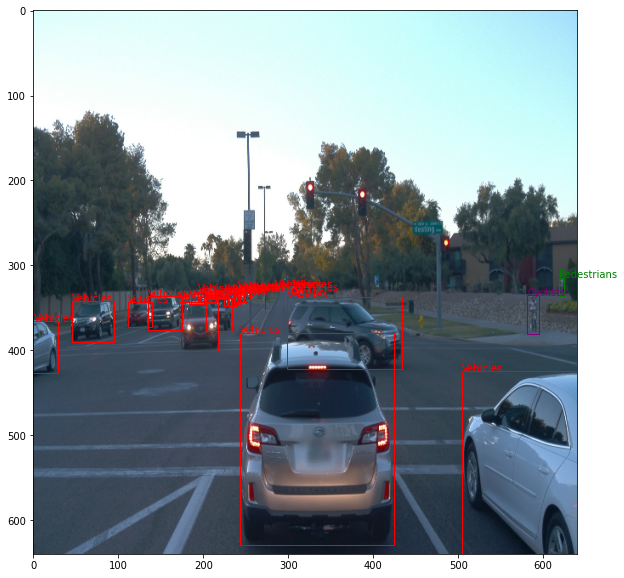

In [25]:

import pandas as pd
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

##Unknown:0, Vehicles: 1, Pedestrians: 2, Cyclists: 3, Signs (removed)
INSTANCE_CATEGORY_NAMES = [
    'Unknown', 'Vehicles', 'Pedestrians', 'Cyclists'
]
INSTANCE_Color = {
    'Unknown':'black', 'Vehicles':'red', 'Pedestrians':'green', 'Cyclists':'purple'
}#'Unknown', 'Vehicles', 'Pedestrians', 'Cyclists'


def show_oneimage_category(image, label, boundingbox):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    len=label.size
    print(len)
    for index in range(len):
        box= boundingbox[index]
        print(box)
        labelid=label[index]
        labelname=INSTANCE_CATEGORY_NAMES[labelid]
        print("Class id:", labelid)
        classcolor=INSTANCE_Color[labelname]
        [xmin, ymin, xmax, ymax]=box*IMAGE_SIZE[0]
        # Draw the object bounding box.
        ax.add_patch(patches.Rectangle(
        xy=(ymin,
            xmin),
        width=ymax-ymin,
        height=xmax-xmin,
        linewidth=1,
        edgecolor=classcolor, #'red',
        facecolor='none'))
        ax.text(ymin, xmin, labelname, color=classcolor, fontsize=10)
            
  
    plt.imshow(image)
  #plt.title(CLASSES[label_batch.numpy()])

testimage=decoded_tensors['image']
testlabel=decoded_tensors['groundtruth_classes'].numpy()
testboundingbox=decoded_tensors['groundtruth_boxes'].numpy()
show_oneimage_category(testimage, testlabel, testboundingbox)

In [26]:
pwd

'/data/cmpe249-f20/Shifa'

In [27]:
MODELS_CONFIG = {
    'fasterrcnnresnet50_640': 
    {
        'model_name': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8',
        'base_pipeline_file': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz',
        'batch_size':4
    },
    'ssdmobilenetv2fpn640_640':
    {
        'model_name': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz',
        'batch_size':4
    }
                   }

chosen_model = 'ssdmobilenetv2fpn640_640'#'efficientdet-d0'

num_steps = 90000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps


model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size']

In [28]:
print(model_name)

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8


In [29]:
label_map_pbtxt_fname = '/home/014530971/waymo_labelmap.txt'
label_map_pbtxt_fname

'/home/014530971/waymo_labelmap.txt'

In [30]:
pipeline_fname = "/data/cmpe249-f20/Shifa/" + model_name + '/pipeline.config' #+ base_pipeline_file
fine_tune_checkpoint = "/data/cmpe249-f20/Shifa/" + model_name + '/checkpoint/ckpt-0'
label_map_pbtxt_fname = '/home/014530971/waymo_labelmap.txt'
from object_detection.utils import label_map_util

def get_num_classes(pbtxt_fname):
    #import label_map_util
    
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
num_classes

3

In [31]:
pipeline_fname

'/data/cmpe249-f20/Shifa/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/pipeline.config'

In [32]:
fine_tune_checkpoint

'/data/cmpe249-f20/Shifa/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0'

In [33]:
train_record_fname = "/data/cmpe249-f20/Shifa/TFRecordTrain--00000-of-00005.tfrecord" #"./tfrecords/TFRecords-Train*"
test_record_fname = "/data/cmpe249-f20/Shifa/TFRecordVal--00000-of-00005.tfrecord" #./tfrecords/TFRecords-Val*"
label_map_pbtxt_fname = '/home/014530971/waymo_labelmap.txt'

In [34]:
%cd /home/014530971/models/research

/home/014530971/models/research


In [35]:

#write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re
print('writing custom configuration file')
#PATHT = "/data/cmpe249-f20/Shifa/TFRecordTrain--00000-of-00005.tfrecord"
#PATHV ="/data/cmpe249-f20/Shifa/TFRecordVal--00000-of-00005.tfrecord"
#PATHL = '/home/014530971/waymo_labelmap.txt'
with open(pipeline_fname) as f:
    s = f.read()
    print(s)
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    print("Tune_checkpoint")
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    print(s)
    print("\n")
    
    # tfrecord files train and test.
    print("Train and Test----------------------------------------------------------------------------------------------")
    s = re.sub(
        '(input_path: ".*?)(TFRecordTrain--00000-of-00005.tfrecord)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(TFRecordVal--00000-of-00005.tfrecord)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)
    print(s)
    print("\n")

    # label_map_path
    print("Label")
    s = re.sub(
        '(label_map_path: ".*?)(waymo_labelmap.txt)(.*?")', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)
    print(s)
    print("\n")

    # Set training batch_size.
    print("Batch size")
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)
    print(s)
    print("\n")

    # Set training steps, num_steps
    print("num_steps")
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    print(s)
    print("\n")
    
    # Set number of classes num_classes
    print("num_classes")
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    print(s)
    print("\n")
    
    #fine-tune checkpoint type
    print("checkpoint")
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
    print(s)
    print("\n")
        
    f.write(s)

writing custom configuration file
model {
  ssd {
    num_classes: 90
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.9999998989515007e-05
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      use_depthwise: true
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
        additional_layer_depth: 128
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scal

In [36]:
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

#check GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
Tensorflow Version:  2.3.1
Keras Version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [37]:
INSTANCE_CATEGORY_NAMES[1]

'Vehicles'

In [38]:
!ls /data/cmpe249-f20/Shifa

exported-models
json_TFRecordTrain-.json
json_TFRecordVal-.json
myoutputmodel
pipeline_file.config
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
TFRecordTrain--00000-of-00005.tfrecord
TFRecordTrain--00001-of-00005.tfrecord
TFRecordTrain--00002-of-00005.tfrecord
TFRecordTrain--00003-of-00005.tfrecord
TFRecordTrain--00004-of-00005.tfrecord
TFRecordVal--00000-of-00005.tfrecord
TFRecordVal--00001-of-00005.tfrecord
TFRecordVal--00002-of-00005.tfrecord
TFRecordVal--00003-of-00005.tfrecord
TFRecordVal--00004-of-00005.tfrecord


In [39]:
ls

a3c_blogpost/        delf/                       pcl_rl/
adversarial_text/    dist/                       pipeline_file.config
attention_ocr/       efficient-hrl/              README.md
audioset/            lfads/                      rebar/
autoaugment/         lstm_object_detection/      seq_flow_lite/
build/               marco/                      setup.py
cognitive_planning/  myoutputmodel/              slim/
cvt_text/            nst_blogpost/               vid2depth/
deeplab/             object_detection/
deep_speech/         object_detection.egg-info/


In [40]:
cd ..

/home/014530971/models


In [41]:
cd /home/014530971

/home/014530971


In [42]:
pwd

'/home/014530971'

In [43]:
ls

=2.0.1            protoc-3.9.2-linux-x86_64.zip  Trial_shifa.ipynb
bin/              readme.txt                     Untitled1.ipynb
include/          RL.ipynb                       Untitled.ipynb
libcublas.so.10*  Small.ipynb                    venv-3.6.6-gpu/
models/           traffic.jpg                    waymo_labelmap.txt


In [44]:
cd models

/home/014530971/models


In [45]:
ls

AUTHORS     community/       ISSUES.md  official/  README.md
CODEOWNERS  CONTRIBUTING.md  LICENSE    orbit/     research/


In [46]:
cd research

/home/014530971/models/research


In [47]:
ls

a3c_blogpost/        delf/                       pcl_rl/
adversarial_text/    dist/                       pipeline_file.config
attention_ocr/       efficient-hrl/              README.md
audioset/            lfads/                      rebar/
autoaugment/         lstm_object_detection/      seq_flow_lite/
build/               marco/                      setup.py
cognitive_planning/  myoutputmodel/              slim/
cvt_text/            nst_blogpost/               vid2depth/
deeplab/             object_detection/
deep_speech/         object_detection.egg-info/


In [48]:
cd object_detection

/home/014530971/models/research/object_detection


In [49]:
pwd

'/home/014530971/models/research/object_detection'

In [50]:
!which python

/home/014530971/venv-3.6.6-gpu/bin/python


In [51]:
PIPELINE_CONFIG_PATH='/data/cmpe249-f20/Shifa/pipeline_file.config'
MODEL_DIR='/data/cmpe249-f20/Shifa/myoutputmodel'
!python model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --alsologtostderr
#!zip myoutputmodel_ssd.zip -r ./myoutputmodel

2020-12-08 10:25:06.235766: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-08 10:25:09.712207: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-08 10:25:09.718357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2020-12-08 10:25:09.718401: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-08 10:25:09.719909: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-12-08 10:25:09.722146: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuff

In [51]:
pwd

'/home/014530971/models/research/object_detection'

In [52]:
cd /data/cmpe249-f20/Shifa/myoutputmodel

/data/cmpe249-f20/Shifa/myoutputmodel


In [53]:
ls

checkpoint                   ckpt-89.data-00000-of-00001
ckpt-85.data-00000-of-00001  ckpt-89.index
ckpt-85.index                ckpt-90.data-00000-of-00001
ckpt-86.data-00000-of-00001  ckpt-90.index
ckpt-86.index                ckpt-91.data-00000-of-00001
ckpt-87.data-00000-of-00001  ckpt-91.index
ckpt-87.index                eval/
ckpt-88.data-00000-of-00001  train/
ckpt-88.index


In [54]:
PIPELINE_CONFIG_PATH='/data/cmpe249-f20/Shifa/pipeline_file.config'
MODEL_DIR='/data/cmpe249-f20/Shifa/myoutputmodel'
CHECKPOINT_DIR='/data/cmpe249-f20/Shifa/myoutputmodel'
!python /home/014530971/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --checkpoint_dir={CHECKPOINT_DIR} \
    --alsologtostderr

2020-12-08 13:55:13.544418: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
W1208 13:55:17.308209 140497733564224 model_lib_v2.py:1026] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I1208 13:55:17.308418 140497733564224 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1208 13:55:17.308516 140497733564224 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I1208 13:55:17.308626 140497733564224 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1208 13:55:17.308742 140497733564224 model_lib_v2.py:1041] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2020-12-08 13:55:17.319838: I tensorflow/stream_executor/

In [58]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 10015: logdir monocular_depth_estimation/tmp (started 5 days, 20:58:02 ago; pid 169750)


In [60]:
%tensorboard --logdir /data/cmpe249-f20/Shifa/myoutputmodel

UsageError: Line magic function `%tensorboard` not found.


In [61]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 10015: logdir monocular_depth_estimation/tmp (started 5 days, 21:00:45 ago; pid 169750)


In [63]:
PIPELINE_CONFIG_PATH='/data/cmpe249-f20/Shifa/pipeline_file.config'
!python /home/014530971/models/research/object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path {PIPELINE_CONFIG_PATH} --trained_checkpoint_dir /data/cmpe249-f20/Shifa/myoutputmodel --output_directory /data/cmpe249-f20/Shifa/exported-models

2020-12-08 15:11:08.918626: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-08 15:11:14.641286: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-08 15:11:14.647498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2020-12-08 15:11:14.647541: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-08 15:11:14.649018: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-12-08 15:11:14.651347: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuff

In [64]:
ls /data/cmpe249-f20/Shifa/exported-models

checkpoint/  pipeline.config  saved_model/


In [65]:
import time
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/data/cmpe249-f20/Shifa/exported-models/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 10.431015253067017s


In [66]:
label_map_path='/home/014530971/waymo_labelmap.txt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

0.03364968299865723


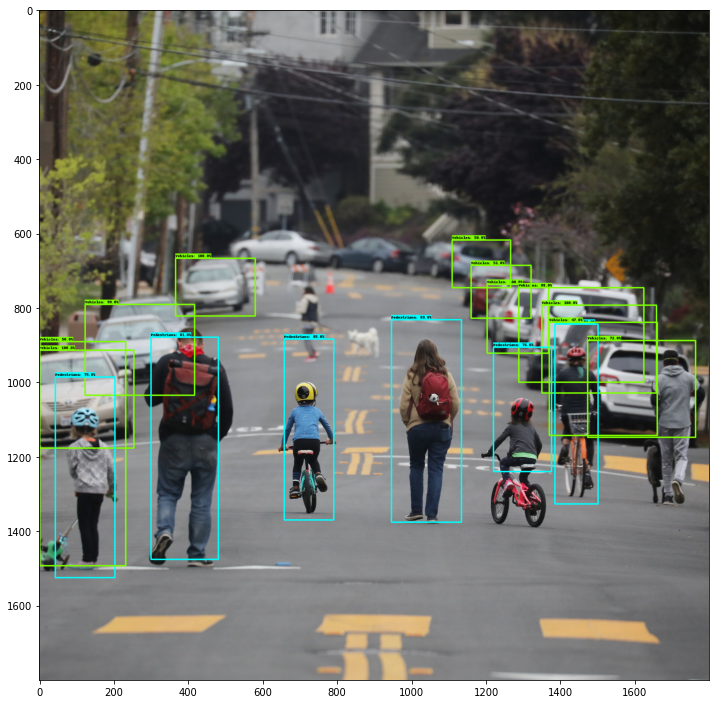

In [69]:
image_path = os.path.join('/home/014530971/' + 'traffic1' + '.jpg')
#image_np = load_image_into_numpy_array(image_path)
img_data = tf.io.gfile.GFile(image_path, 'rb').read()
image = Image.open(BytesIO(img_data))
(im_width, im_height) = image.size
image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

input_tensor = np.expand_dims(image_np, 0)
start_time = time.time()
detections = detect_fn(input_tensor)
end_time = time.time()
print(end_time - start_time)

plt.rcParams['figure.figsize'] = [42, 21]
label_id_offset = 1
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.int32),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.40,
      agnostic_mode=False)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

0.0478975772857666


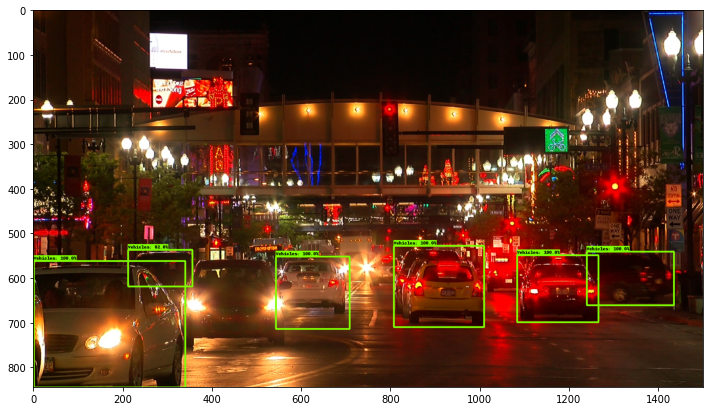

In [70]:
image_path = os.path.join('/home/014530971/' + 'traffic2' + '.jpg')
#image_np = load_image_into_numpy_array(image_path)
img_data = tf.io.gfile.GFile(image_path, 'rb').read()
image = Image.open(BytesIO(img_data))
(im_width, im_height) = image.size
image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

input_tensor = np.expand_dims(image_np, 0)
start_time = time.time()
detections = detect_fn(input_tensor)
end_time = time.time()
print(end_time - start_time)

plt.rcParams['figure.figsize'] = [42, 21]
label_id_offset = 1
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.int32),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.40,
      agnostic_mode=False)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

0.03015899658203125


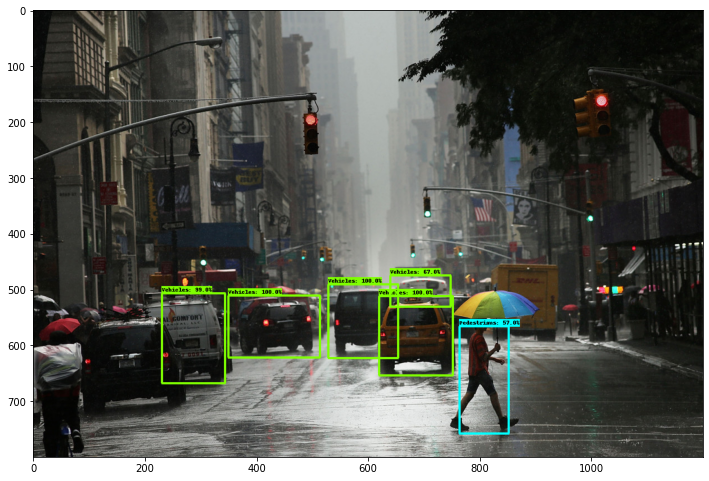

In [71]:
image_path = os.path.join('/home/014530971/' + 'traffic3' + '.jpg')
#image_np = load_image_into_numpy_array(image_path)
img_data = tf.io.gfile.GFile(image_path, 'rb').read()
image = Image.open(BytesIO(img_data))
(im_width, im_height) = image.size
image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

input_tensor = np.expand_dims(image_np, 0)
start_time = time.time()
detections = detect_fn(input_tensor)
end_time = time.time()
print(end_time - start_time)

plt.rcParams['figure.figsize'] = [42, 21]
label_id_offset = 1
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.int32),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.40,
      agnostic_mode=False)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()


0.0289003849029541


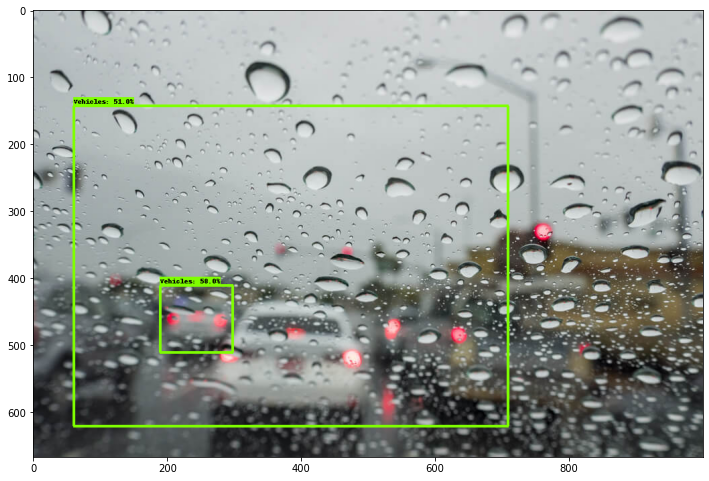

In [72]:
image_path = os.path.join('/home/014530971/' + 'traffic4' + '.jpg')
#image_np = load_image_into_numpy_array(image_path)
img_data = tf.io.gfile.GFile(image_path, 'rb').read()
image = Image.open(BytesIO(img_data))
(im_width, im_height) = image.size
image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

input_tensor = np.expand_dims(image_np, 0)
start_time = time.time()
detections = detect_fn(input_tensor)
end_time = time.time()
print(end_time - start_time)

plt.rcParams['figure.figsize'] = [42, 21]
label_id_offset = 1
image_np_with_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.int32),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.40,
      agnostic_mode=False)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()